In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.feature import StopWordsRemover, VectorAssembler
from pyspark.ml.feature import IDF
from pyspark.ml import Pipeline, PipelineModel
import numpy as np
from pyspark.ml.evaluation import RegressionEvaluator


from pyspark.sql.functions import *
from pyspark.sql.types import *

import time
from IPython.display import Image, display
import findspark

findspark.init()

sc = SparkContext()
spark = SparkSession.builder.appName("FinalProject").getOrCreate()

# Get sparkcontext from
sqlContext = SQLContext(sc)

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [16]:
#spark.stop()

In [2]:
spark

## About the dataset

In [7]:
# đọc dữ liệu bảng book-ratings
ratings = spark.read.csv("../Data/BX-Book-Ratings.csv", sep=";", header=True, encoding="latin1")

In [4]:
ratings.show()

+-------+----------+-----------+
|User-ID|      ISBN|Book-Rating|
+-------+----------+-----------+
| 276725|034545104X|          0|
| 276726|0155061224|          5|
| 276727|0446520802|          0|
| 276729|052165615X|          3|
| 276729|0521795028|          6|
| 276733|2080674722|          0|
| 276736|3257224281|          8|
| 276737|0600570967|          6|
| 276744|038550120X|          7|
| 276745| 342310538|         10|
| 276746|0425115801|          0|
| 276746|0449006522|          0|
| 276746|0553561618|          0|
| 276746|055356451X|          0|
| 276746|0786013990|          0|
| 276746|0786014512|          0|
| 276747|0060517794|          9|
| 276747|0451192001|          0|
| 276747|0609801279|          0|
| 276747|0671537458|          9|
+-------+----------+-----------+
only showing top 20 rows



In [5]:
ratings.select("Book-Rating").distinct().count()

11

In [6]:
ratings.printSchema()

root
 |-- User-ID: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: string (nullable = true)



In [7]:
# đọc dữ liệu bảng users
users = spark.read.csv("../Data/BX-Users.csv", sep=";", header=True, encoding="latin1")

In [8]:
users.show(20)

+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      1|  nyc, new york, usa|NULL|
|      2|stockton, califor...|  18|
|      3|moscow, yukon ter...|NULL|
|      4|porto, v.n.gaia, ...|  17|
|      5|farnborough, hant...|NULL|
|      6|santa monica, cal...|  61|
|      7| washington, dc, usa|NULL|
|      8|timmins, ontario,...|NULL|
|      9|germantown, tenne...|NULL|
|     10|albacete, wiscons...|  26|
|     11|melbourne, victor...|  14|
|     12|fort bragg, calif...|NULL|
|     13|barcelona, barcel...|  26|
|     14|mediapolis, iowa,...|NULL|
|     15|calgary, alberta,...|NULL|
|     16|albuquerque, new ...|NULL|
|     17|chesapeake, virgi...|NULL|
|     18|rio de janeiro, r...|  25|
|     19|           weston, ,|  14|
|     20|langhorne, pennsy...|  19|
+-------+--------------------+----+
only showing top 20 rows



In [9]:
users.printSchema()

root
 |-- User-ID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)



In [10]:
# đọc dữ liệu từ bảng books
books = spark.read.csv("../Data/BX_Books.csv", sep=";", header=True, encoding="latin1")

In [11]:
books.count()

271379

In [12]:
summary = spark.read.parquet("../Data/Summaryyy.parquet")

In [13]:
summary.show()

+----------+--------------------+
|      ISBN|             Summary|
+----------+--------------------+
|0195153448|Provides an intro...|
|0002005018|In a small town i...|
|0060973129|Here, for the fir...|
|0374157065|Describes the gre...|
|0393045218|A look at the inc...|
|0399135782|A Chinese immigra...|
|0425176428|Essays by respect...|
|0679425608|An authoritative,...|
|074322678X|Now back in print...|
|0771074670|Another story bas...|
|080652121X|Hitler&#39;s Secr...|
|1575663937|This eye-opening,...|
|1881320189|A beautifully nar...|
|0440234743|A suicidal billio...|
|0452264464|Staring unflinchi...|
|0609804618|The staff of The ...|
|1841721522|In New Vegetarian...|
|1879384493|Provides advice o...|
|0061076031|Problems arise wh...|
|0439095026|As explained by t...|
+----------+--------------------+
only showing top 20 rows



In [14]:
books.show(10,False)

+----------+--------------------------------------------------------------------------------------------------+--------------------+-------------------+------------------------+------------------------------------------------------------+------------------------------------------------------------+------------------------------------------------------------+
|ISBN      |Book-Title                                                                                        |Book-Author         |Year-Of-Publication|Publisher               |Image-URL-S                                                 |Image-URL-M                                                 |Image-URL-L                                                 |
+----------+--------------------------------------------------------------------------------------------------+--------------------+-------------------+------------------------+------------------------------------------------------------+----------------------------------------

In [15]:
books = books.join(summary, on = "ISBN", how= "inner")

In [16]:
books.show(20,False)

+----------+--------------------------------------------------------------------------------------------+------------------------------+-------------------+----------------------------+------------------------------------------------------------+------------------------------------------------------------+------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ISBN      |Book-Title                                                                                  |Book-Author                   |Year-Of-Publication|Publisher                   |Image-URL-S                                                 |Image-URL-M                                                 |Image-URL-L                                                 |Summary               

### Merge

In [17]:
# join 3 bảng lại với nhau
df = ratings.join(users, on= 'User-ID')
df = df.join(books, on = 'ISBN')


In [18]:
df.count()

632238

In [19]:
df.show(10)

+----------+-------+-----------+--------------------+----+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|User-ID|Book-Rating|            Location| Age|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|             Summary|
+----------+-------+-----------+--------------------+----+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|0000913154| 171118|          8|toronto, ontario,...|  47|The Way Things Wo...|C. van Amerongen ...|               1967|    Simon & Schuster|http://images.ama...|http://images.ama...|http://images.ama...|Scientific princi...|
|0001711253| 156534|          0|whitehaven, engla...|  26|  The Big Honey Hunt|     Stan Berenst

### Changing Datatypes

In [20]:
# chuyển đổi kiểu dữ liệu String - Integer
df = df.withColumn("Age", df["Age"].cast(IntegerType()))
df = df.withColumn("Year-Of-Publication", df["Year-Of-Publication"].cast(IntegerType()))
df = df.withColumn("Book-Rating", df["Book-Rating"].cast(IntegerType()))
df = df.withColumn("User-ID", df["User-ID"].cast(IntegerType()))
# df = df.withColumn("ISBN", df["ISBN"].cast(IntegerType()))

df = df.withColumn("location_array", split(df["location"], ", "))
df = df.withColumn("country", df["location_array"][2])
df = df.drop("location_array")

In [21]:
# xóa các kí tự chữ cái trong ISBN và chuyển về kiểu int
df = df.withColumn(
    "ISBN",
    when(

        expr("substring(ISBN, -1, 1) = 'X'"),

        expr("substring(ISBN, 1, length(ISBN) - 1)"),

    ).otherwise(col("ISBN")),
)


df = df.withColumn("ISBN", df["ISBN"].cast(IntegerType()))

# df_with_X = df.filter((expr("substring(ISBN, -1, 1) = 'X'"))
# )


### Handling null value

In [22]:
# đếm cột Age có bao nhiêu giá trị null
df.where((col("Age").isNull())).count()

171441

In [23]:
# thực hiện thay thế giá trị null cột Age bằng giá trị trung bình của cột
average_age = df.select(avg("Age")).collect()[0][0]
df = df.withColumn("Age", when(col("Age").isNull(), int(average_age)).otherwise(col("Age")))

In [24]:
# xóa những rating có giá trị = 0 ra khỏi tập dữ liệu, có thể là do người dùng chưa thực hiện rating hoặc có lỗi trong quá trình thu thập
df = df.filter(df["Book-Rating"] != 0)

# in ra tổng số dòng của dữ liệu sau khi xử lí
df.count()

df = df.dropna(subset=["ISBN"])
df = df.drop("Image-URL-S")
df = df.drop("Image-URL-L")

## Visualization

In [25]:
# chuyển spark dataframe về pandas dataframe
df_1 = df.toPandas()

### Rating distribution

Text(0.5, 1.0, 'Rating Distribution')

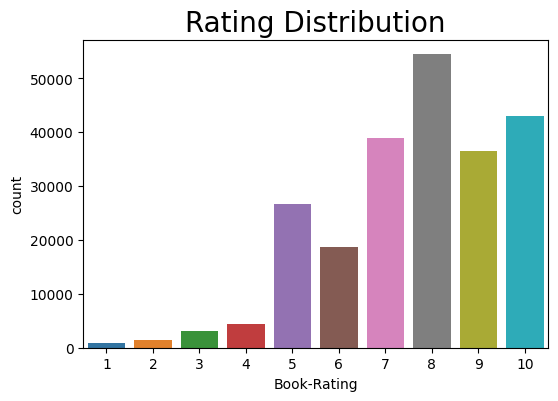

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 


plt.figure(figsize=(6,4))
sns.countplot(x='Book-Rating',data=df_1)
plt.title('Rating Distribution',size=20)

In [27]:
ds = df_1["Book-Author"].value_counts().head(50).reset_index()
ds.columns = ["author", "count"]
ds.head()

,author,count
0,Stephen King,2694
1,Nora Roberts,1989
2,John Grisham,1663
3,J. K. Rowling,1262
4,Mary Higgins Clark,1016


### Authors with most Rating.

Text(0.5, 1.0, 'Authors with most Ratings')

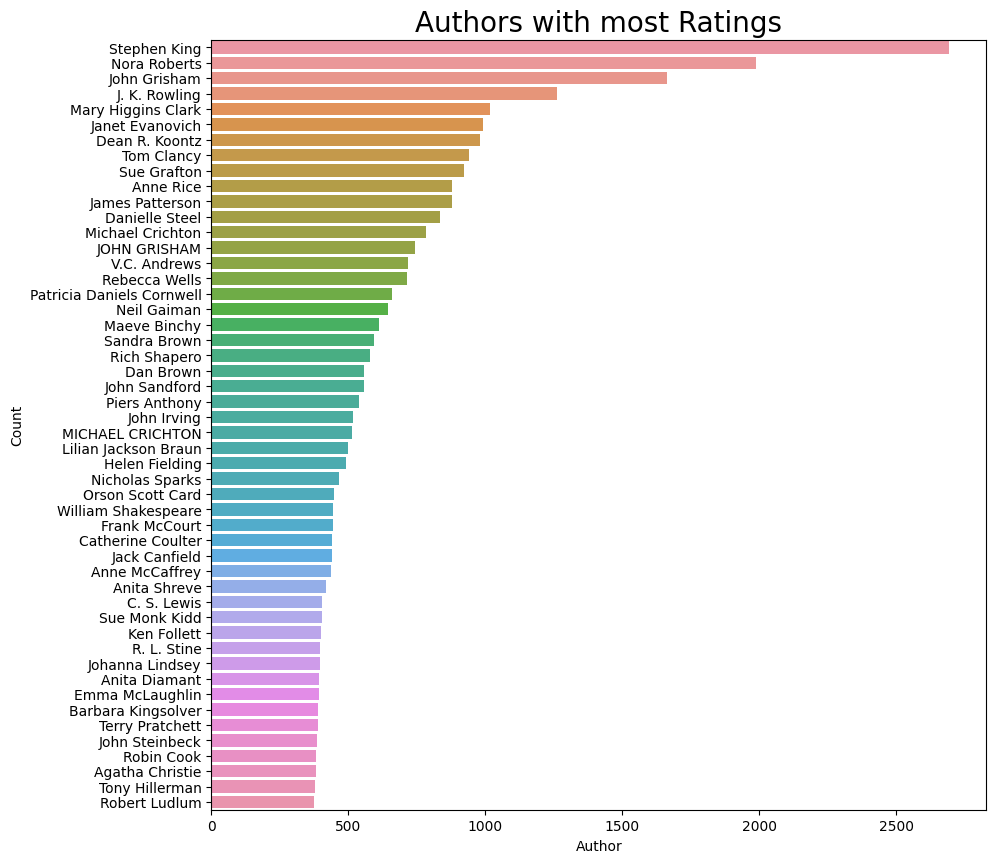

In [28]:
plt.figure(figsize=(10, 10))
sns.barplot(x="count", y="author", data=ds)
plt.xlabel("Author")
plt.ylabel("Count")
plt.title("Authors with most Ratings", size=20)

### Books with most Ratings.

In [29]:
ds = df_1["Book-Title"].value_counts().head(50).reset_index()
ds.columns = ["book", "count"]
ds.head()

,book,count
0,Wild Animus,581
1,The Da Vinci Code,488
2,The Secret Life of Bees,403
3,The Nanny Diaries: A Novel,393
4,The Red Tent (Bestselling Backlist),383


Text(0.5, 1.0, 'Books with most Ratings')

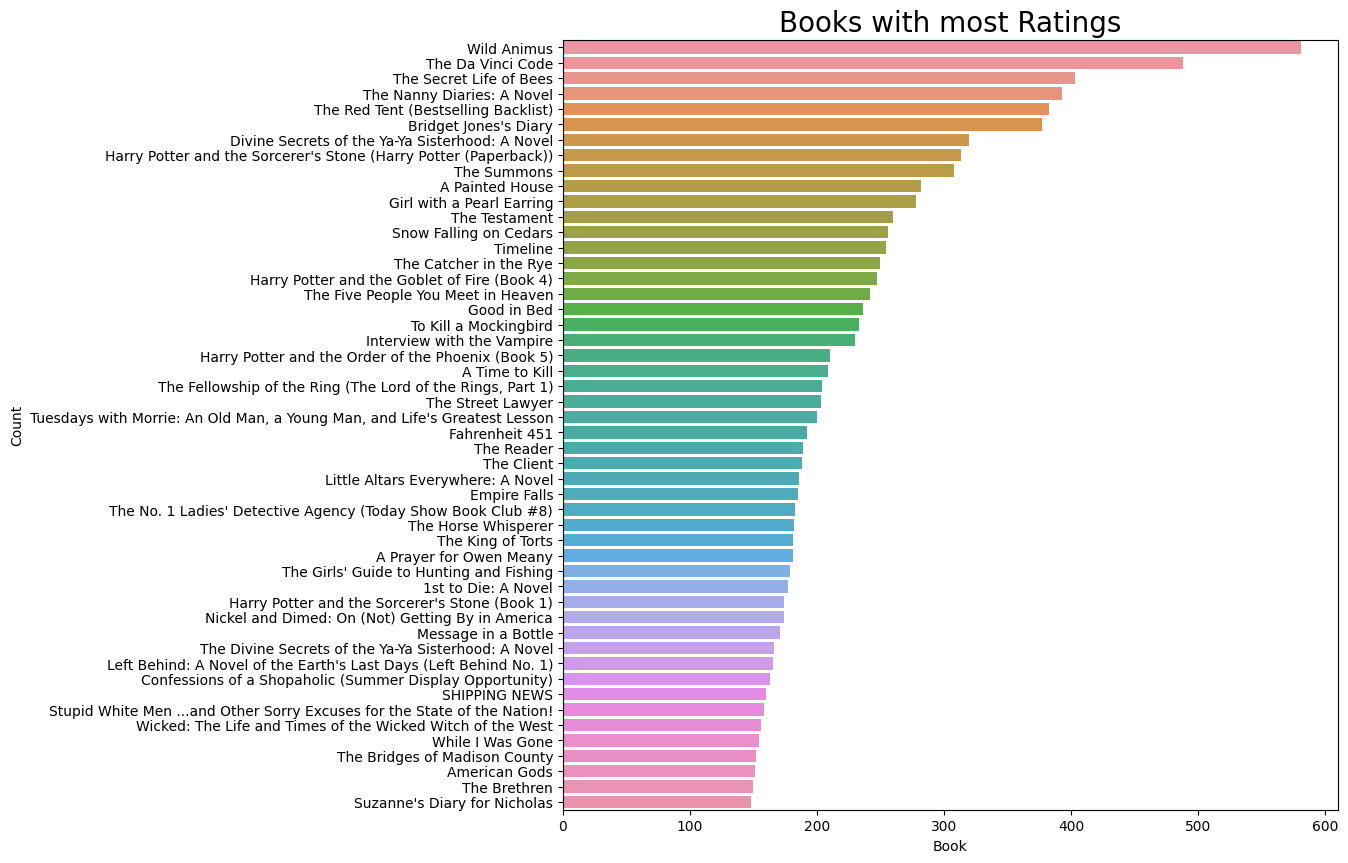

In [30]:
plt.figure(figsize=(10, 10))
sns.barplot(x="count", y="book", data=ds)
plt.xlabel("Book")
plt.ylabel("Count")
plt.title("Books with most Ratings", size=20)

### Countries with most ratings

In [31]:
ds = df_1["country"].value_counts().head(50).reset_index()
ds.columns = ["country", "count"]
ds.head(20)

,country,count
0,usa,168041
1,canada,21989
2,united kingdom,7552
3,australia,3928
4,n/a,3884
5,germany,2157
6,portugal,1857
7,spain,1458
8,malaysia,1341
9,france,1023


Text(0.5, 1.0, 'Countries with most Ratings')

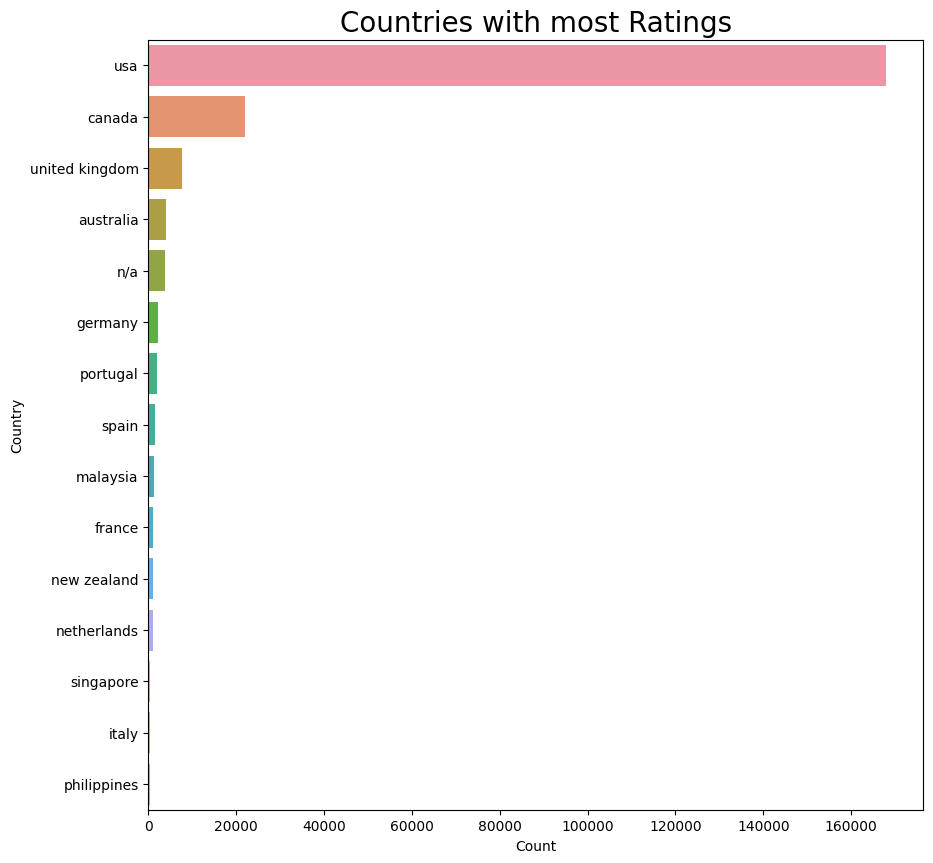

In [32]:
plt.figure(figsize=(10, 10))
sns.barplot(x="count", y="country", data=ds.head(15))
plt.xlabel("Count")
plt.ylabel("Country")
plt.title("Countries with most Ratings", size=20)

### Age Distribution 

C:\Users\DELL\AppData\Local\Temp\ipykernel_6264\284208419.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_1["Age"], kde=False)


Text(0.5, 1.0, 'Age Distribution')

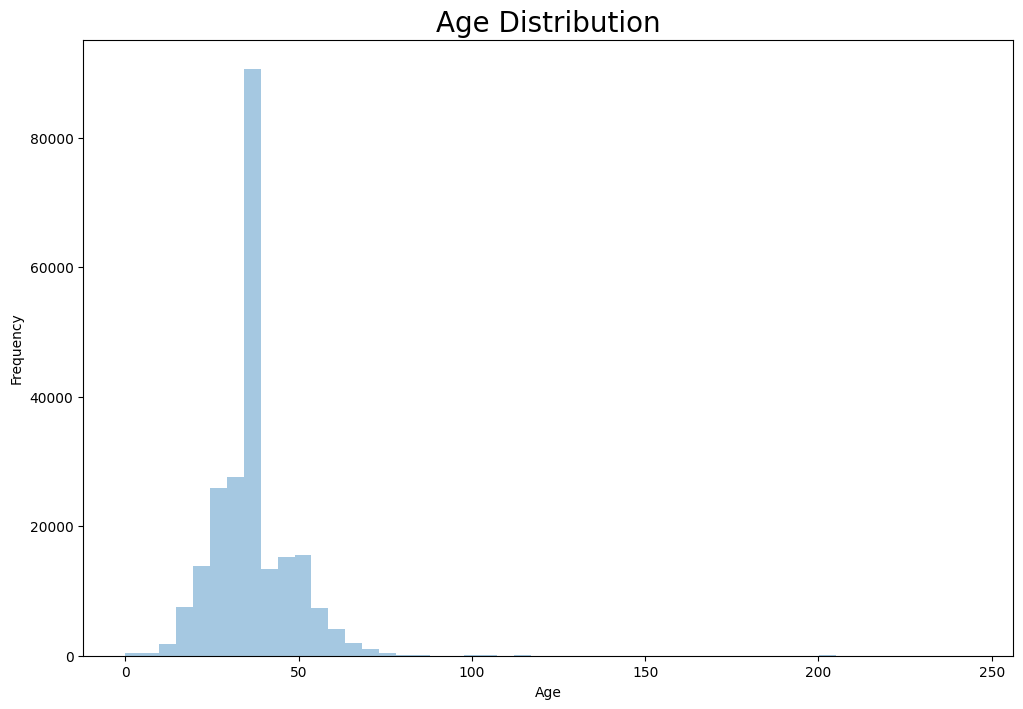

In [33]:
plt.figure(figsize=(12, 8))
sns.distplot(df_1["Age"], kde=False)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution", size=20)

### Collaborative Filtering ALS 

In [49]:
# null_isbn = df.filter(df["ISBN"].isNull())
# null_isbn.count()


Train, test split

In [25]:
training_df, validation_df  = df.randomSplit([.7,.3],seed= 22)


Train model 

In [35]:
start_time = time.time()

# khởi tạo các tham số
als = ALS(
    maxIter=15,
    regParam=1,
    rank=10,
    userCol="User-ID",
    itemCol="ISBN",
    ratingCol="Book-Rating",
    coldStartStrategy="drop",
    nonnegative=True
)

model = als.fit(training_df)

predictions = model.transform(validation_df)
# đánh giá mô hình bằng giá trị RMSE


end_time = time.time()
execution_time = end_time - start_time

print("Time execute: ", execution_time, " giây")

Time execute:  76.62789034843445  giây


Evaluation

In [36]:
evaluator = RegressionEvaluator(
    metricName="rmse", labelCol="Book-Rating", predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print("RMSE value", str(rmse))

RMSE value 2.225044688080628


Cross Validator

In [53]:
# als = ALS(
#     rank=10,
#     maxIter=10,
#     regParam=0.15,
#     userCol="User-ID",
#     itemCol="ISBN",
#     ratingCol="Book-Rating",
#     coldStartStrategy="drop",
#     nonnegative=True
# )
# print("Load complete als model")
# print(als)


paramGrid = (
    ParamGridBuilder()
    .addGrid(als.maxIter, [5,10,15])
    .addGrid(als.regParam, [0.01, 0.1, 1])
    .addGrid(als.rank, [10,20,30,40])
    .build()
)

evaluator = RegressionEvaluator(
    metricName="rmse", labelCol="Book-Rating", predictionCol="prediction"
)

cv = CrossValidator(
    estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5
)

best_model = cv.fit(training_df)
model = best_model.bestModel
print(model)

In [ ]:
print("Best params:")
print("maxIter:", model._java_obj.parent().getMaxIter()) # 15
print("regParam:", model._java_obj.parent().getRegParam()) # 1
print("rank:", model._java_obj.parent().getRank()) # 40

Best params:
maxIter: 15
regParam: 1.0
rank: 10


In [26]:
# als = ALS(
#     maxIter=10,
#     regParam=1,
#     rank=10,
#     userCol="User-ID",
#     itemCol="ISBN",
#     ratingCol="Book-Rating",
#     coldStartStrategy="drop",
# )

# model = als.fit(training_df)

predictions = model.transform(validation_df)

evaluator = RegressionEvaluator(

    metricName="rmse", labelCol="Book-Rating", predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(str(rmse))

2.8243486250441063


In [ ]:
predictions.select("User-ID", "Book-Title", "Book-Rating", "prediction").orderBy(
    col("User-ID")
).show(10, False)

+-------+-----------------------------------------------------------------------------+-----------+----------+
|User-ID|Book-Title                                                                   |Book-Rating|prediction|
+-------+-----------------------------------------------------------------------------+-----------+----------+
|53     |A Soldier of the Great War                                                   |9          |2.444243  |
|99     |Pasquale's Nose: Idle Days in an Italian Town                                |7          |6.519011  |
|99     |The Pillars of the Earth                                                     |3          |7.263886  |
|114    |Dead Aim                                                                     |9          |7.675826  |
|165    |Little Altars Everywhere: A Novel                                            |9          |3.3659801 |
|232    |Pride and Prejudice (Dover Thrift Editions)                                  |8          |2.668887  |
|

In [ ]:
for_one_user = predictions.filter(col("User-ID") == 98391).select(
    "User-ID", "Book-Title", "Image-URL-M", "Book-Rating", "prediction"
)

In [ ]:
for_one_user.show(5,False)

+-------+---------------------------------------------------------+------------------------------------------------------------+-----------+----------+
|User-ID|Book-Title                                               |Image-URL-M                                                 |Book-Rating|prediction|
+-------+---------------------------------------------------------+------------------------------------------------------------+-----------+----------+
|98391  |Flirting With Trouble (Harlequin American Romance Series)|http://images.amazon.com/images/P/037375020X.01.MZZZZZZZ.jpg|8          |3.5247073 |
|98391  |Anything Goes (Harlequin Blaze, 112)                     |http://images.amazon.com/images/P/037379116X.01.MZZZZZZZ.jpg|9          |7.190652  |
|98391  |The Rake: Lessons in Love                                |http://images.amazon.com/images/P/038082082X.01.MZZZZZZZ.jpg|8          |7.850499  |
|98391  |Key of Light (Key Trilogy (Paperback))                   |http://images.amazon.

In [ ]:
for book in for_one_user.take(5):
    print(book["Book-Title"])
    display(Image(url=book["Image-URL-M"]))

Flirting With Trouble (Harlequin American Romance Series)


Anything Goes (Harlequin Blaze, 112)


The Rake: Lessons in Love


Key of Light (Key Trilogy (Paperback))


The Reluctant Suitor


In [ ]:
userRecommend = model.recommendForAllUsers(5)
bookRecommend = model.recommendForAllItems(5)

In [ ]:
userRecommend.printSchema()

In [ ]:
userRecommend.select("User-ID", "recommendations.ISBN").orderBy(
    "User-ID"
).show(10, False)

In [ ]:
userRecommend.show(10,False)

In [ ]:
bookRecommend.select("ISBN", "recommendations.User-ID").show(10, False)

In [ ]:
userSubsetRecs = model.recommendForUserSubset(users, 3)

In [ ]:
userSubsetRecs.show(10,False)

### Content-based

In [ ]:
# books = books.withColumn(
#     "ISBN",
#     when(
#         expr("substring(ISBN, -1, 1) = 'X'"),
#         expr("substring(ISBN, 1, length(ISBN) - 1)"),
#     ).otherwise(col("ISBN")),
# )


# books = books.withColumn("ISBN", books["ISBN"].cast(IntegerType()))

In [ ]:
books.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)
 |-- Summary: string (nullable = true)



In [ ]:
books = books.drop(col("Image-URL-S"))
books = books.drop(col("Image-URL-L"))

In [ ]:
book_sample = books.sample(0.02, seed=123)
book_sample.show(5, False)
book_sample.count()

+----------+-----------------------------------------+--------------+-------------------+---------------------+------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ISBN      |Book-Title                               |Book-Author   |Year-Of-Publication|Publisher            |Image-URL-M                                                 |Summary                                                                                                                                                                                                                        |
+----------+-----------------------------------------+--------------+-------------------+---------------------+------------------------------------------------------------+----------------------------------

2776

In [ ]:
text = book_sample.select("ISBN", "Summary")
text.show(3,False)

+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ISBN      |Summary                                                                                                                                                                                                                                                                 |
+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|8478887342|El último encuentro es una novela que hurga de tal manera en el alma\nhumana que logra esa tensión que pone al lector en vilo hasta que\nllega al final de

In [ ]:
from operator import add

text_by_book = text.rdd.map(tuple).reduceByKey(add)
columns = ["ISBN", "Summary"]
text_by_book_df = spark.createDataFrame(text_by_book, schema=columns)
text_by_book_df.show(3,False)

text_by_book_df.count()

+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ISBN      |Summary                                                                                                                                                                                                                                                                 |
+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0375702652|A journalist describes his motorcycle odyssey through modernday South\nAmerica as he searched for the people and places in Ernesto\n&quot;Che&quot; Guevar

2801

In [ ]:
tokenizer = RegexTokenizer(
    pattern="\w+", inputCol="Summary", outputCol="tokens", toLowercase=True, gaps=False
)
stopWordsRemover = StopWordsRemover(inputCol="tokens", outputCol="nostopwords")
countVectorizer = CountVectorizer(
    inputCol="nostopwords", outputCol="tf", vocabSize=1000
)
tfiDF = IDF(inputCol="tf", outputCol="tfidf_vec")
pipeline = Pipeline(stages=[tokenizer, stopWordsRemover, countVectorizer, tfiDF])


# Fit the model
pipeline_model = pipeline.fit(text_by_book_df)

# save the pipeline model
# pipeline_model.write().overwrite().save("pipeline_model")

In [ ]:
# pipeline_model = PipelineModel.load("pipeline_model")

In [ ]:
# convert the review data into feature vectors
transformed_text_by_books = pipeline_model.transform(text_by_book_df)
transformed_text_by_books.show(3)
transformed_text_by_books.count()

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|             Summary|              tokens|         nostopwords|                  tf|           tfidf_vec|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|0375702652|A journalist desc...|[a, journalist, d...|[journalist, desc...|(1000,[0,1,36,58,...|(1000,[0,1,36,58,...|
|0789308169|A pop-up book fea...|[a, pop, up, book...|[pop, book, featu...|(1000,[4,19,67,42...|(1000,[4,19,67,42...|
|1879916029|&quot;--George O....|[quot, george, o,...|[quot, george, o,...|(1000,[0,1,24,146...|(1000,[0,1,24,146...|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



2801

In [ ]:
def cosineSimilarity(vector1, vector2):
    numerator = np.dot(vector1, vector2)
    denominator = np.sqrt(np.dot(vector1, vector1)) * np.sqrt(np.dot(vector2, vector2))

    return float(numerator / denominator)

In [ ]:
all_books_tfidf = transformed_text_by_books.select("ISBN", "tfidf_vec").rdd.map(
    lambda x: (x[0], x[1])
)

In [ ]:
def getBookDetails(sim_book):
    book_details = sim_book.join(books, "ISBN", "inner").select(
        "ISBN",
        "similarity_score",
        "Book-Title",
        "Book-Author",
        "Year-Of-Publication",
        "Publisher",
        "Image-URL-M",
        "Summary",
    )

    return book_details

In [ ]:
def keyWordsRecommendation(keyword, all_books_tfidf):
    input_word_df = sc.parallelize([(0, keyword)]).toDF(["ISBN", "Summary"])

    # For getting recommendation based on a keywords, first we need to transform it
    # into word vector. So, we will load our pipelined model that we saved earlier
    input_word_df = pipeline_model.transform(input_word_df)

    # Get word2vectors data for this keyword
    input_word_tfidf = input_word_df.select("tfidf_vec").collect()[0][0]

    # Get similarity
    similar_books_rdd = all_books_tfidf.map(
        lambda x: (x[0], cosineSimilarity(x[1], input_word_tfidf))
    )

    sim_book_by_keyword = (
        similar_books_rdd.toDF(["ISBN", "similarity_score"])
        .dropna()
        .orderBy("similarity_score", ascending=False)
        .limit(10)
    )

    return sim_book_by_keyword

In [ ]:
# Key word similarity in review text for recommendation
key_word = "divorced women"

print(f"\nBooks similar to keyword - {key_word}")
sim_books_keyword = keyWordsRecommendation(key_word, all_books_tfidf)

# Get details of these similar restaurants
sim_books_keyword_details = getBookDetails(sim_books_keyword)
sim_books_keyword_details.cache()
sim_books_keyword_details.orderBy("similarity_score", ascending=False).show(10, False)


Books similar to keyword - divorced women
+----------+-------------------+-----------------------------------------------------------------------------------------------------+----------------------+-------------------+----------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ISBN      |similarity_score   |Book-Title                                                                                           |Book-Author           |Year-Of-Publication|Publisher                         |Image-URL-M                                                 |Summary                                                                                                                                                                          

In [ ]:
book_sample.show(10,False)

+----------+---------------------------------------------------------------------------------+----------------------+-------------------+------------------------+------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ISBN      |Book-Title                                                                       |Book-Author           |Year-Of-Publication|Publisher               |Image-URL-M                                                 |Summary                                                                                                                                                                                                                                                       |
+----------+------------------------------